In [ ]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Calculating & Investigating final number density plot

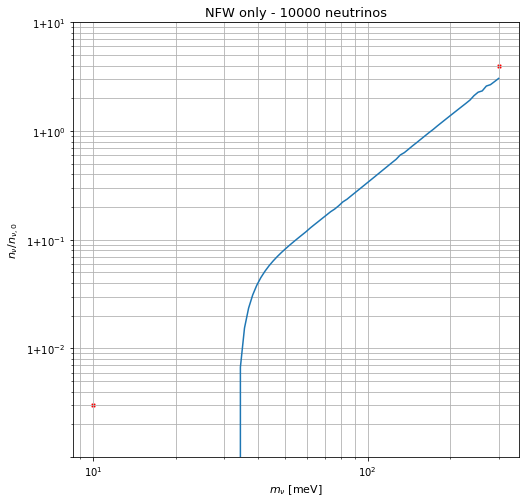

Max value: 4.046640624668397 0.036130719863110686


In [2]:
from shared.preface import *
import shared.functions as fct
import shared.my_units as my
import shared.control_center as CC

# Load data, which function uses.
u_all = fct.load_u_sim()
def number_density_1_mass(m_sim_eV, m_nu_eV, average=False):

    n_nus = np.zeros(len(m_nu_eV))
    for i, m_eV in enumerate(m_nu_eV):

        # Get momenta.
        p, _ = fct.u_to_p_eV(u_all, m_sim_eV, m_eV)

        if average:
            # Calculate number density, values are averaged for z in [3.5, 4].
            idx = np.array(np.where(CC.ZEDS >= 3.5)).flatten()

            temp = np.zeros(len(idx))
            for j,k in enumerate(idx):
                val = fct.number_density(p[:k,0], p[:k,-1]).value
                temp[j] = val

            n_nus[i] = np.mean(temp)

        else:
            n_nus[i] = fct.number_density(p[:,0], p[:,-1]).value

    np.save('neutrino_data/number_densities.npy', n_nus)



# 10 to 300 meV like in the paper
mass_range_eV = np.geomspace(0.01, 0.3, 100)*unit.eV

number_density_1_mass(CC.NU_MASS, mass_range_eV, average=True)
n_nus = np.load('neutrino_data/number_densities.npy')/CC.N0

# Plotting:
fig, ax = plt.subplots(1,1, figsize=(8,8))

ax.plot(mass_range_eV*1e3, (n_nus-1))
x_ends = [1e1, 3*1e2]
y_ends = [3*1e-3, 4]
ax.scatter(x_ends, y_ends, s=12, marker='x', c='r')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'NFW only - {CC.NR_OF_NEUTRINOS} neutrinos')
ax.set_xlabel(r'$m_{\nu}$ [meV]')
ax.set_ylabel(r'$n_{\nu} / n_{\nu, 0}$')
ax.set_ylim(1e-3, 1e1)
plt.grid(True, which="both", ls="-")

ax.yaxis.set_major_formatter(ticker.FuncFormatter(fct.y_fmt))

plt.savefig(f'check_plots/densities_{CC.NR_OF_NEUTRINOS}_nus.pdf')
plt.show()

print('Max value:', np.max(n_nus), np.max(n_nus/CC.N0))

## Fermi-Dirac shape

0.3918684331939805 0.3918684331939805


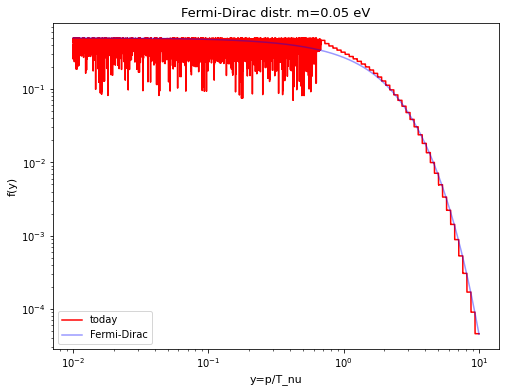

In [10]:
# Load velocities of sim.
u_all = fct.load_u_sim()
u0, u1 = u_all[:,0,:], u_all[:,-1,:]

# Get momenta with of mass used in sim.
p0, _ = fct.u_to_p_eV(u0, CC.NU_MASS, CC.NU_MASS)
p1, _ = fct.u_to_p_eV(u1, CC.NU_MASS, CC.NU_MASS)

# Sort.
order = p0.argsort()
p0_sort, p1_sort = p0[order], p1[order]

# Original Fermi-Dirac distr.
pOG = np.geomspace(CC.LOWER*my.T_nu_eV, CC.UPPER*my.T_nu_eV, len(p0_sort))
FDvalsOG = fct.Fermi_Dirac(pOG)
yOG = pOG/my.T_nu_eV.value

# Fermi-Dirac distr. of initial momentum (by using p1 momenta at z_back)
FDvals0 = fct.Fermi_Dirac(p1_sort)

print(np.mean(FDvals0[0:5000]), np.mean(FDvals1[0:5000]))

# plt.rcParams["figure.figsize"] = (8,6)  # global
plt.figure(figsize=(8,6))
plt.loglog(yOG, FDvals0, label='today', c='red')
plt.loglog(yOG, FDvalsOG, label='Fermi-Dirac', c='blue', alpha=0.4)
plt.title('Fermi-Dirac distr. m=0.05 eV')
plt.ylabel('f(y)')
plt.xlabel('y=p/T_nu')
plt.legend(loc='lower left')
plt.savefig('check_plots/fermi_dirac_distr.pdf')
plt.show()